Import Libraries

In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Function to Smooth the Signal

In [29]:
# Function to smooth the behavioral signal using a Gaussian window
def find_finger_events(tr):
    # Create a Gaussian window of size 80
    x = np.arange(1, 81)
    gs = np.exp(-((x - 40)**2) / 160)
    gs_norm = gs / np.sum(gs)  # Normalize to sum to 1
    
    # Apply convolution between the signal and the Gaussian window
    tra = np.convolve(tr, gs_norm, mode='same')
    return tra


Function to Detect Event Start Points

In [30]:
# Function to detect event start points and local minima
def find_event_starts(tra):
    # Threshold calculation: mean + standard deviation
    thresh = np.mean(tra) + np.std(tra)
    
    # Identify points exceeding the threshold
    a1 = tra > thresh
    
    # Check surrounding values for maxima conditions
    a2_tra = np.concatenate([tra[1:], [0]])  # Shift left
    a3_tra = np.concatenate([[0], tra[:-1]])  # Shift right
    a2 = (tra - a2_tra) > 0
    a3 = (tra - a3_tra) > 0
    a = np.where(a1 & a2 & a3)[0]  # Combine conditions
    
    # Detect local minima
    b2 = np.diff(np.concatenate(([0], tra))) < 0  # Downward slope
    b3 = np.diff(np.concatenate((tra, [0]))) > 0  # Upward slope
    closest_min = np.where(b2 & b3)[0]  # Combine conditions
    
    return a, closest_min


Main Function to Calculate ERP

In [31]:
# Function to calculate ERP and return the averaged signals for each finger
def calc_mean_erp(trial_points, ecog_data):
    # Load trial points and brain signal data
    trial_points_from_csv = pd.read_csv(trial_points, names=['start', 'peak', 'finger'], header=0)
    ecog_data_from_csv = pd.read_csv(ecog_data, header=None).squeeze()
    
    # Parameters
    pre_start = 200  # 200 ms before the start of movement
    post_start = 1000  # 1000 ms after the start of movement
    window_length = pre_start + post_start + 1  # Total window size = 1201
    
    # Initialize a dictionary to store signals by finger
    signals_by_finger = {finger: [] for finger in range(1, 6)}
    
    # Extract windows for each trial
    for _, row in trial_points_from_csv.iterrows():
        start_idx = int(row['start'])  # Convert to integer
        finger = int(row['finger'])  # Ensure finger is also an integer

        # Extract the brain signal window
        if start_idx - pre_start >= 0 and start_idx + post_start < len(ecog_data_from_csv):
            segment = ecog_data_from_csv[start_idx - pre_start:start_idx + post_start + 1]
            signals_by_finger[finger].append(segment)

    
    # Calculate the average ERP for each finger
    fingers_erp_mean = []
    for finger in range(1, 6):
        if signals_by_finger[finger]:
            avg_signal = np.mean(signals_by_finger[finger], axis=0)
            fingers_erp_mean.append(avg_signal)
        else:
            fingers_erp_mean.append(np.zeros(window_length))
    
    fingers_erp_mean = np.array(fingers_erp_mean)
    
    # Plot the ERP for each finger
    plt.figure(figsize=(10, 6))
    for finger, avg_signal in enumerate(fingers_erp_mean, start=1):
        plt.plot(avg_signal, label=f"Finger {finger}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Brain Response (µV)")
    plt.title("Averaged ERP by Finger")
    plt.legend()
    plt.show()
    
    return fingers_erp_mean


Load and Process the Data

In [32]:
# Load the finger data and preprocess it
finger_data_file = '../../data/finger_data.csv'
finger_data = pd.read_csv(finger_data_file).iloc[:, 0]  # Use the first column as the behavioral signal

# Smooth the signal using the Gaussian window
smoothed_signal = find_finger_events(finger_data)

# Detect the start points and local minima
start_points, local_minima = find_event_starts(smoothed_signal)


Calculate and Plot ERP

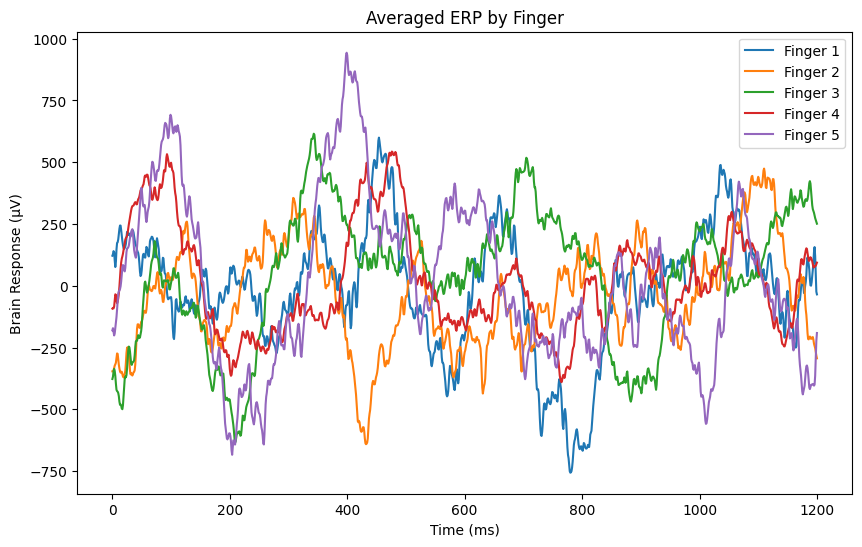

ERP Matrix (5x1201):
[[ 121.5859375   128.078125    140.1796875  ...   42.8125
   -23.765625    -34.859375  ]
 [-346.25210084 -345.36134454 -342.79831933 ... -267.57983193
  -281.78991597 -293.69747899]
 [-377.33333333 -367.99166667 -346.64166667 ...  265.88333333
   258.375       251.18333333]
 [ -92.44736842  -89.54210526  -91.61578947 ...   81.10526316
    87.2          93.63684211]
 [-180.35135135 -171.59459459 -185.48648649 ... -294.05405405
  -222.86486486 -191.21621622]]


In [33]:
# File paths for trial points and brain signal data
trial_points_file = '../../data/events_file_ordered.csv'
ecog_data_file = '../../data/brain_data_channel_one.csv'

# Calculate the ERP and obtain the ERP matrix
erp_matrix = calc_mean_erp(trial_points_file, ecog_data_file)

# Print the ERP matrix
print("ERP Matrix (5x1201):")
print(erp_matrix)
